In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier


In [2]:
data = pd.read_csv("dataset.csv")


In [3]:
data.columns = data.columns.str.strip()
print("Columns:", data.columns)



Columns: Index(['index', 'having_IPhaving_IP_Address', 'URLURL_Length',
       'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting',
       'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State',
       'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token',
       'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH',
       'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover',
       'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord',
       'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page',
       'Statistical_report', 'Result'],
      dtype='object')


In [4]:
possible_targets = ['class', 'label', 'result', 'target', 'CLASS_LABEL']

target_col = None
for col in data.columns:
    if col.lower() in [t.lower() for t in possible_targets]:
        target_col = col
        break

if target_col is None:
    # assume last column is target
    target_col = data.columns[-1]

print("Detected target column:", target_col)


Detected target column: Result


In [5]:
print("\nTarget distribution before cleaning:")
print(data[target_col].value_counts(dropna=False))



Target distribution before cleaning:
 1    6157
-1    4898
Name: Result, dtype: int64


In [6]:
data = data.dropna(subset=[target_col])




In [7]:
# Convert strings to numeric if needed
data[target_col] = data[target_col].astype(str).str.lower()

data[target_col] = data[target_col].replace({
    'legitimate': 0,
    'phishing': 1,
    '-1': 0,
    '1': 1
})

data[target_col] = pd.to_numeric(data[target_col], errors='coerce')




In [8]:
data = data[data[target_col].isin([0, 1])]


In [9]:
print("\nTarget distribution after cleaning:")
print(data[target_col].value_counts())

if data[target_col].nunique() < 2:
    raise ValueError(" Dataset has only ONE class. Cannot train ML model.")



Target distribution after cleaning:
1    6157
0    4898
Name: Result, dtype: int64


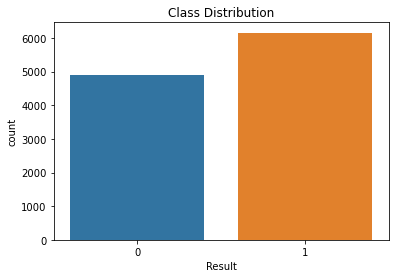

In [10]:
sns.countplot(x=target_col, data=data)
plt.title("Class Distribution")
plt.show()




In [11]:
X = data.drop(target_col, axis=1)
y = data[target_col]


In [12]:
X = pd.get_dummies(X, drop_first=True)



In [13]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



In [27]:
# ---------------- CREATE TRAIN & TEST DATA FILES ----------------

feature_names = X.columns.tolist()
target_col = "CLASS_LABEL"

# Convert scaled arrays back to DataFrames
train_df = pd.DataFrame(X_train, columns=feature_names)
train_df[target_col] = y_train.values

test_df = pd.DataFrame(X_test, columns=feature_names)
test_df[target_col] = y_test.values

# Save to CSV files
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

print("✅ Train and Test data files created")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


✅ Train and Test data files created
Train shape: (8844, 32)
Test shape: (2211, 32)


In [15]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [16]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [17]:
y_pred = xgb_model.predict(X_test)


In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9687924016282226


In [19]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       980
           1       0.97      0.98      0.97      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



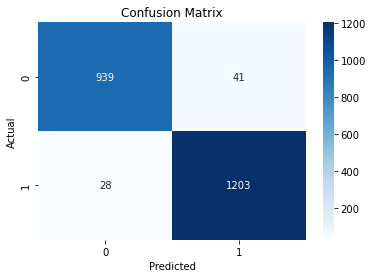

In [20]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


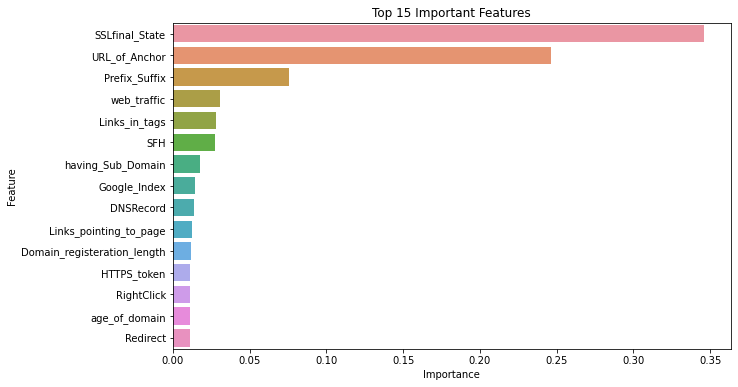

In [21]:
importance = xgb_model.feature_importances_
feature_names = X.columns

feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(15))
plt.title("Top 15 Important Features")
plt.show()


In [22]:
import pickle

# Save the trained model
with open("xgboost_phishing_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)

print("Model saved as xgboost_phishing_model.pkl")


Model saved as xgboost_phishing_model.pkl


In [23]:
# Save the scaler
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

print(" Scaler saved as scaler.pkl")


 Scaler saved as scaler.pkl


In [24]:
import pickle

feature_names = X.columns.tolist()

with open("feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)

print(" feature_names.pkl saved")


 feature_names.pkl saved


In [25]:
import pickle
import numpy as np

# Load trained XGBoost model
with open("xgboost_phishing_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Load scaler
with open("scaler.pkl", "rb") as file:
    loaded_scaler = pickle.load(file)

print(" Model and scaler loaded successfully")


 Model and scaler loaded successfully


In [26]:

sample = X.iloc[0:1].values   # perfect shape
sample_scaled = loaded_scaler.transform(sample)

prediction = loaded_model.predict(sample_scaled)
print(prediction)


[0]


C:\Users\PYTHON 3\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
